In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from scipy.ndimage import gaussian_filter
from siphon.ncss import NCSS

In [2]:
def near_neighbor(xi,yi,xk,yk,phi):
    grid = np.zeros((len(yi),len(xi)))
    for e in range(len(xi)):
        for f in range(len(yi)):
            dum_dist = 10000000.
            for g in range(len(xk)):
                dist = (((xk[g]-xi[e])**2) + ((yk[g]-yi[f])**2))**(0.5)
                if (dist <= dum_dist):
                    dum_dist = dist
                    dum_phi = phi[g]
                elif (dist == dum_dist):
                    dum_phi = (dum_phi + phi[g])/2.
            grid[f,e] = dum_phi
    return gaussian_filter(grid,sigma=2)

def barnes_guess(x_i,y_i,x_k,y_k,phi_0,roi):
    grid = np.zeros((len(y_i),len(x_i)))
    # Loop through the grid and update the initial grid with the observations
    for l in range(len(x_i)):
        for m in range(len(y_i)):
            sum_weight = 0.
            num_weight = 0.
            weight     = 0.
            for p in range(len(phi_0)): # Loop for the observations
                # Determining the distance between the observation and a grid point
                rad2 = ((x_k[p]-x_i[l])**2 + (y_k[p]-y_i[m])**2)**(1/2)
                weight = np.exp(-(rad2**2)/(roi**2))
                sum_weight+=weight
                weight_phi = weight * phi_0[p] # 
                num_weight+=weight_phi
            grid[m,l] = num_weight/sum_weight
    return gaussian_filter(grid, sigma=2)

def cressman(x_i, y_i, x_k, y_k, phi_0, guess_field):
    # Estimate of grid at Obs points
    h = np.zeros(len(phi_0)).astype('float')

    # Assimilated Grid
    grid = np.zeros((len(y_i),len(x_i)))
    #print(grid.shape)

    # Begin the Cressman Scheme, doing three passes with Radius of Influence (roi)
    # of 80, 50, and 40 grid points
    for i in [1,2,3]:
        if (i == 1):
            roi = 15.**2.
        elif (i == 2):
            roi = 10.**2.
        else:
            roi = 5.**2.

            # Calculating the values of the grid at the observation points through simple linear interpolation
        for p in range(len(phi_0)):
            if (np.int(y_k[p]) in y_i) & ((np.int(x_k[p]) in x_i)):
                a = np.where(y_i == np.int(y_k[p]))[0][0]
                a2 = np.abs(y_i[a] - (y_k[p]))
                b = np.where(x_i == np.int(x_k[p]))[0][0]
                b2 = np.abs(x_i[b] - (x_k[p]))
                h[p] = (((guess_field[a,b]*(1-b2)+guess_field[a,b+1]*b2))*(1-a2) +
                        ((guess_field[a-1,b]*(1-b2)+guess_field[a-1,b+1]*b2))*(a2))
            else:
                h[p] = phi_0[p]

    # Loop through the grid and update the initial grid with the observations
        for l in range(len(x_i)):
            for m in range(len(y_i)):
                sum_weight = 0.
                num_weight = 0.
                weight     = 0.
                for p in range(len(phi_0)): # Loop for the observations
                    # Determining the distance between the observation and a grid point
                    rad2 = ((x_k[p]-x_i[l])**2 + (y_k[p]-y_i[m])**2)
                    #print(dist2)
                    if (rad2 <= roi):
                        weight = (roi - rad2)/(roi + rad2) # Setting the weight if within the roi
                    else:
                        weight = 0. # Setting the weight of the ob to zero if outside the roi
                    sum_weight+=weight
                    weight_phi = weight * (phi_0[p] - h[p]) # 
                    num_weight+=weight_phi
                if sum_weight > 0:
                    grid[m,l] = guess_field[m,l] + (num_weight/sum_weight) # Updating the grid
                else:
                    grid[m,l] = guess_field[m,l]



        guess_field = grid   # Saving the grid to use in the next iteration
    return grid

def barnes(x_i, y_i, x_k, y_k, phi_0, guess_field):
    # Estimate of grid at Obs points
    h = np.zeros(len(phi_0)).astype('float')

    # Assimilated Grid
    grid = np.zeros((len(y_i),len(x_i)))

    # Begin the Cressman Scheme, doing three passes with Radius of Influence (roi)
    # of 80, 50, and 40 grid points
    roi = 3
    for i in [1,2]:
        if (i == 1):
            gamma = 1
        elif (i == 2):
            gamma = 0.33

        # Calculating the values of the grid at the observation points through simple linear interpolation
        for p in range(len(phi_0)):
            if (np.int(y_k[p]) in y_i) & ((np.int(x_k[p]) in x_i)):
                a = np.where(y_i == np.int(y_k[p]))[0][0]
                a2 = np.abs(y_i[a] - (y_k[p]))
                b = np.where(x_i == np.int(x_k[p]))[0][0]
                b2 = np.abs(x_i[b] - (x_k[p]))
                h[p] = (((guess_field[a,b]*(1-b2)+guess_field[a,b+1]*b2))*(1-a2) +
                        ((guess_field[a-1,b]*(1-b2)+guess_field[a-1,b+1]*b2))*(a2))
            else:
                h[p] = phi_0[p]

        # Loop through the grid and update the initial grid with the observations
        for l in range(len(x_i)):
            for m in range(len(y_i)):
                sum_weight = 0.
                num_weight = 0.
                weight     = 0.
                for p in range(len(phi_0)): # Loop for the observations
                    # Determining the distance between the observation and a grid point
                    rad2 = ((x_k[p]-x_i[l])**2 + (y_k[p]-y_i[m])**2)**(1/2)
                    weight = np.exp(-(rad2**2)/(gamma*roi**2))
                    sum_weight+=weight
                    weight_phi = weight * (phi_0[p] - h[p]) # 
                    num_weight+=weight_phi
                if sum_weight > 0:
                    grid[m,l] = guess_field[m,l] + (num_weight/sum_weight) # Updating the grid
                else:
                    grid[m,l] = guess_field[m,l]



        guess_field = grid   # Saving the grid to use in the next iteration
    return grid

In [3]:
# Data from https://ruc.noaa.gov/raobs/ mandatory levels for U.S.
# Min Lat: 20 N
# Max Lat: 70 N
# Min Lon: -145 E
# Max Lat: -50 E

import re
from datetime import datetime
filename = '/Users/kgoebber/nwp/20171209_12_RAOB_data.txt'

file_data = open(filename, 'r')

date = []
lat = []
lon = []
stid = []
hght_500 = []

for line in file_data.readlines():
    tmp = line.split()
    if (tmp[0] == '254'):
        _, hour, day, month, year = tmp
        date_string = '%d%s%02d%02d'%(int(year),month,int(day),int(hour))
        date.append(datetime.strptime(date_string,'%Y%b%d%H'))
    elif (tmp[0] == '1'):
        if (len(tmp) == 6):
            west_test = re.split(' | N |S |N|S|W', tmp[3])
            if (len(west_test) == 3):
                west = -1
            else:
                west = 1
            south_test = re.split(' | N|N|E|W', tmp[3])
            if (len(south_test) != 3):
                south = -1
            else:
                south = 1
            tlat, tlon = re.split(' | N |S |N|S|E|W', tmp[3])[:2]
        if (len(tmp) == 7):
            west_test = re.split('W', tmp[4])
            if (len(west_test) == 2):
                west = -1
            else:
                west = 1
            south_test = re.split('N', tmp[3])
            if (len(south_test) == 2):
                south = 1
            else:
                south = -1
            tlat = re.split('N|S', tmp[3])[0]
            tlon = re.split('E|W', tmp[4])[0]
        lat.append(south*float(tlat))
        lon.append(west*float(tlon))
    elif (tmp[0] == '3'):
        stid.append(tmp[1])
    elif (tmp[0] == '4'):
        if (float(tmp[1])/10. == 500):
            hght_500.append(float(tmp[2]))

In [4]:
# Set up geographic region
LLLon = -140.
LLLat = 19.
URLon = -50.
URLat = 70

# Set values for assimilation grid (1x1 degree lat/lon)
lats = np.arange(URLat,LLLat-1,-1)
lons = np.arange(LLLon,URLon+1,1)

clons, clats = np.meshgrid(lons,lats)

In [5]:
# Get the True Data that occurred
ncss = NCSS('http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_onedeg_ana/'+
            'GFS_Global_onedeg_ana_20171209_1200.grib2')

query = ncss.query()

query.variables('Temperature_isobaric',
                'Geopotential_height_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')
query.add_lonlat().vertical_level(50000)
query.lonlat_box(north=URLat,south=LLLat,west=LLLon,east=URLon)

data = ncss.get_data(query)

gfs_hght_500 = data.variables['Geopotential_height_isobaric'][:].squeeze()

In [7]:
# Get First Guess field from 6 hour forecast of GFS
from netCDF4 import Dataset, num2date

data_gfs_first_guess = Dataset('/Users/kgoebber/python_notebooks/GFS_20171209_0600.nc','r')

FG_time = data_gfs_first_guess.variables['time1']
FG_vtimes = num2date(FG_time[:],units=FG_time.units)
print(FG_vtimes[2])
FG_hght_500 = data_gfs_first_guess.variables['Geopotential_height_isobaric'][2,0,:,:]
FG_gfs = FG_hght_500

2017-12-09 12:00:00


In [8]:
# Set firstguess field for Cressman Scheme
# Use the Nearest Neighbor approach to initially fill the grid
FG_NN = near_neighbor(lons,lats,lon,lat,hght_500)
FG_barnes = barnes_guess(lons,lats,lon,lat,hght_500,3)

In [9]:
cress_hght_500 = cressman(lons,lats,lon,lat,hght_500,FG_barnes)
barnes_hght_500 = barnes(lons,lats,lon,lat,hght_500,FG_barnes)

In [10]:
print(np.average(gfs_hght_500 - cress_hght_500))
print(np.average(gfs_hght_500 - barnes_hght_500))
print(np.average(gfs_hght_500 - FG_barnes))

-6.68687296175
-6.71009398091
-7.38719666344


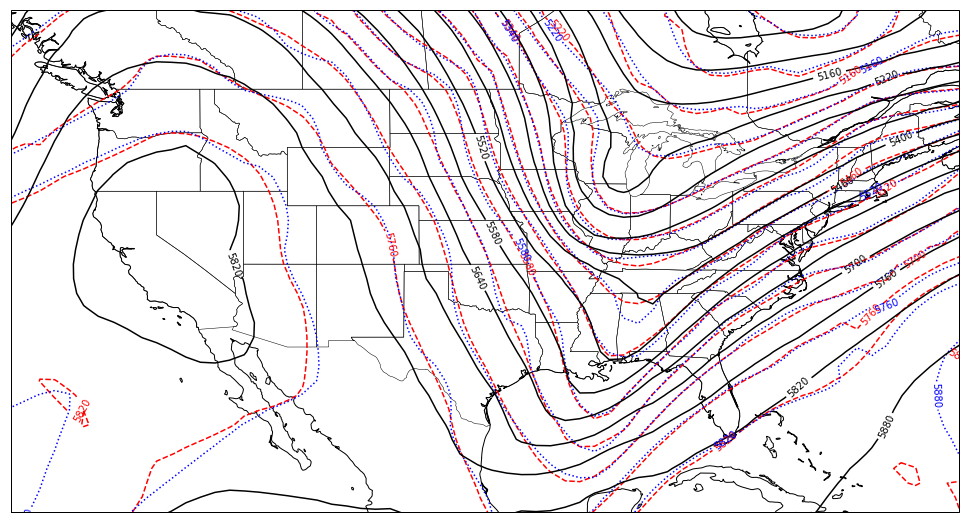

In [11]:
# Get data to plot state and province boundaries
states_provinces = cfeat.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

plotcrs = ccrs.PlateCarree()

fig = plt.figure(1,figsize=(17,11))
ax = fig.add_subplot(111,projection=plotcrs)

ax.set_extent([-130, -65, 20, 50])
ax.coastlines('50m')

ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
cs = ax.contour(clons,clats,cress_hght_500,np.arange(0,7000,60),colors='r',linestyles='dashed')
plt.clabel(cs,fmt='%d')
cs2 = ax.contour(clons,clats,barnes_hght_500,np.arange(0,7000,60),colors='b',linestyles='dotted')
plt.clabel(cs2,fmt='%d')
cs3 = ax.contour(clons,clats,gfs_hght_500,np.arange(0,7000,60),colors='k')
plt.clabel(cs3,fmt='%d')
plt.show()

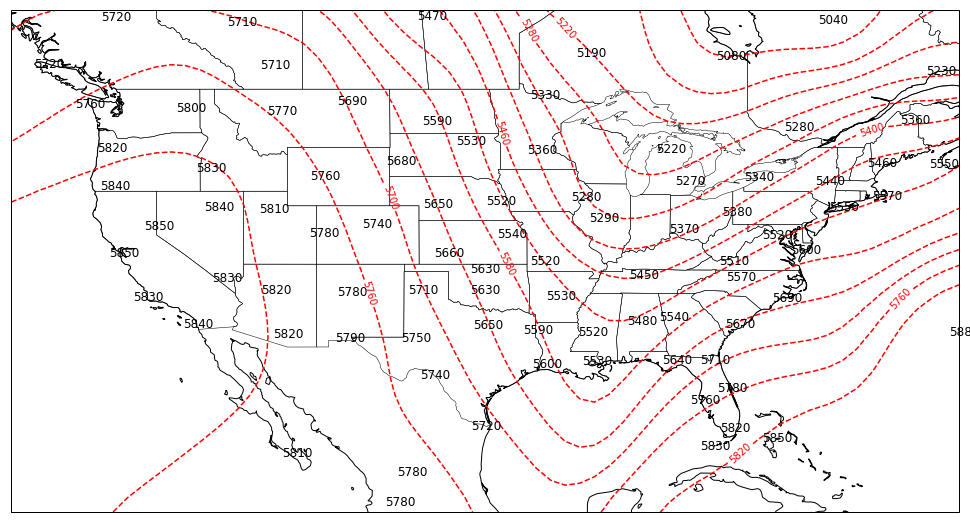

In [12]:
from metpy.plots import StationPlot

plotcrs = ccrs.PlateCarree()

fig = plt.figure(1,figsize=(17,11))
ax = fig.add_subplot(111,projection=plotcrs)

ax.set_extent([-130, -65, 20, 50])
ax.coastlines('50m')
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Set up station plotting using only every third element from arrays for plotting
stationplot = StationPlot(ax, lon, lat,
                          transform=ccrs.PlateCarree(), fontsize=12)
stationplot.plot_parameter('C', hght_500)
cs = ax.contour(clons,clats,FG_barnes,np.arange(0,7000,60),colors='r',linestyles='dashed')
plt.clabel(cs,fmt='%d')
plt.show()